<a href="https://colab.research.google.com/github/datacentertugaskuliah-coder/PraktikumDS/blob/main/Pemrosesan_Data%2C_EDA%2C_Pemodelan%2C_Evaluasi%2C_dan_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

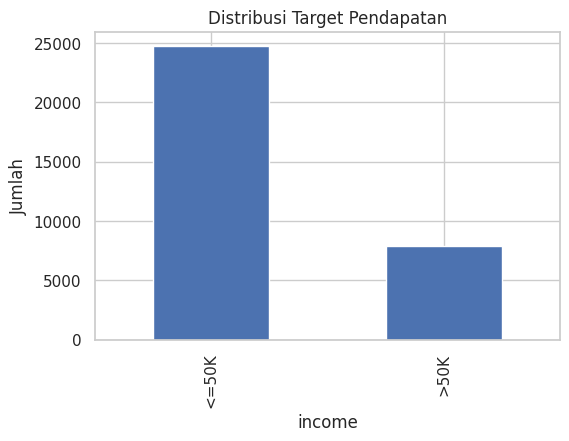

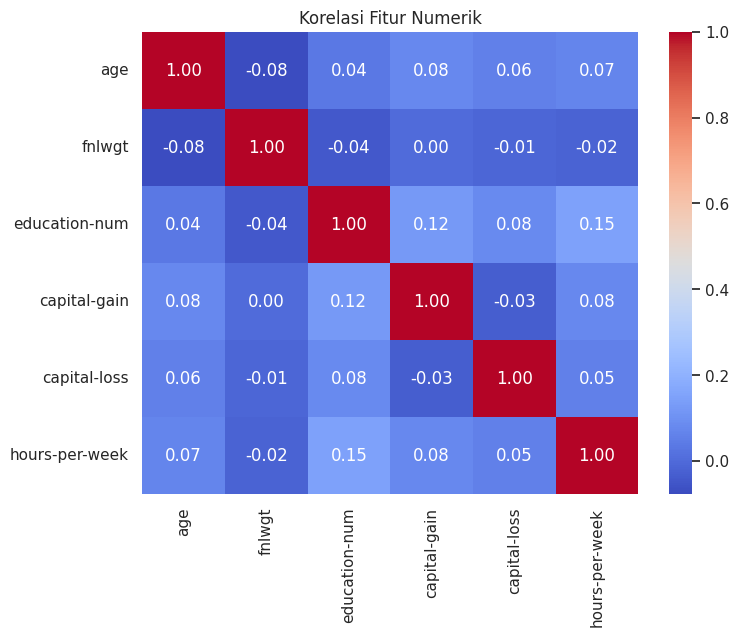

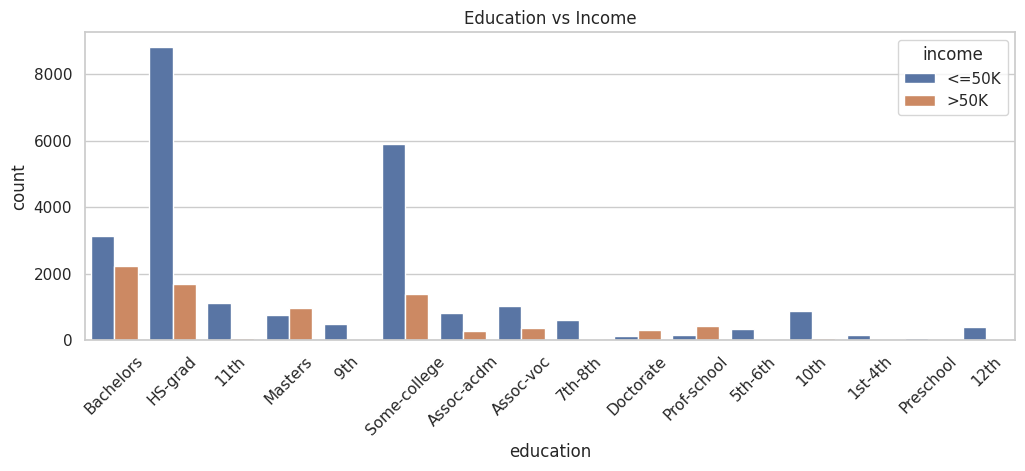

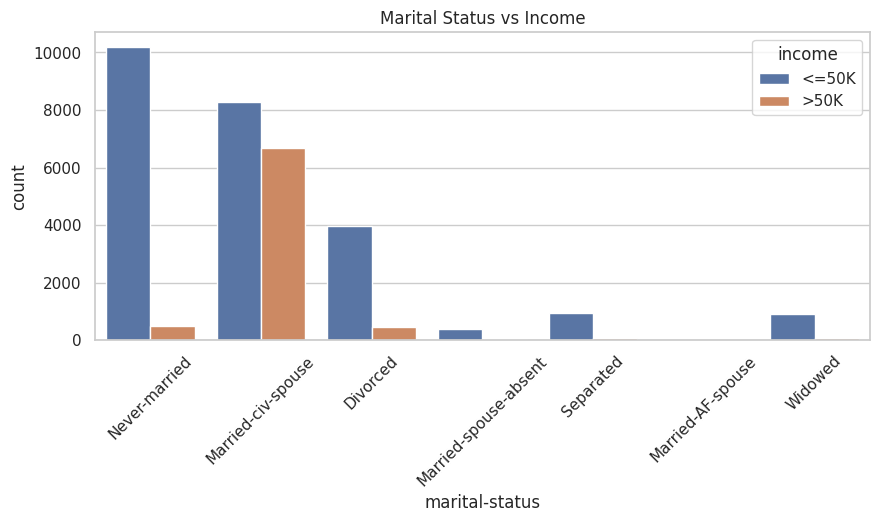

Model : Logistic Regression (Scaled)
Accuracy : 0.8558268079226163
F1 Score : 0.6733913043478261
ROC-AUC  : 0.9078006025463776
----------------------------------------


<Figure size 600x600 with 0 Axes>

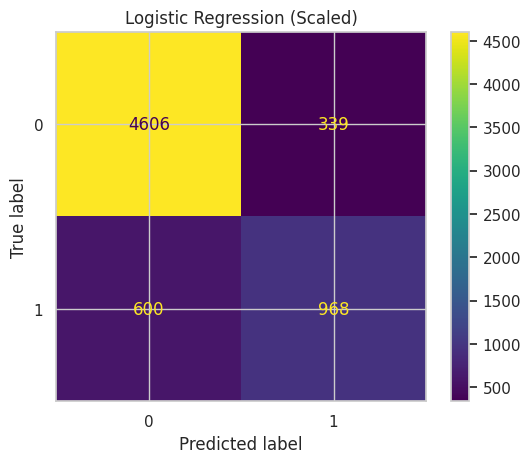

Model : Random Forest
Accuracy : 0.8584369722094273
F1 Score : 0.6816298342541437
ROC-AUC  : 0.9078560595117723
----------------------------------------


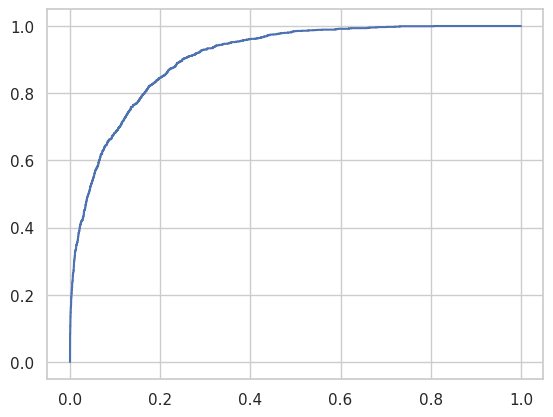

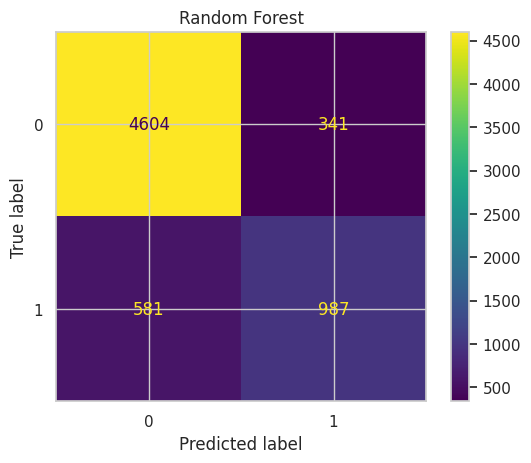

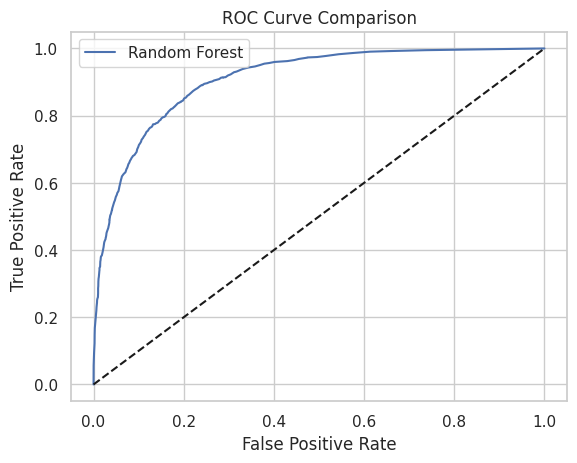

{'Prediksi': '>50K', 'Probabilitas >50K': np.float64(0.515)}

In [2]:
# ==========================================================
# Praktikum Data Science dan Machine Learning Berbasis Python dan UCI Repository
# Pembahasan : Pemrosesan Data, EDA, Pemodelan, Evaluasi, dan Deployment
# Dataset    : Adult / Census Income (UCI Machine Learning Repository)
# Tujuan     : Prediksi Pendapatan Individu (>50K atau <=50K)
# Repo       : https://github.com/datacentertugaskuliah-coder/PraktikumDS.git
# Lingkungan : Google Colab
# ==========================================================


# ==========================================================
# 0. SETUP LINGKUNGAN
# ==========================================================

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve
)

import joblib

sns.set(style="whitegrid")


# ==========================================================
# 1. PEMAHAMAN BISNIS
# ==========================================================
"""
Tujuan:
Memprediksi apakah seseorang memiliki pendapatan tahunan
lebih dari 50K USD berdasarkan karakteristik demografis dan pekerjaan.

Jenis Masalah:
Supervised Learning – Klasifikasi Biner

Target:
>50K  -> 1
<=50K -> 0
"""


# ==========================================================
# 2. PENGUMPULAN DATA
# ==========================================================

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week",
    "native-country", "income"
]

df = pd.read_csv(url, names=columns, sep=", ", engine="python")

df.head()


# ==========================================================
# 3. PEMBERSIHAN DATA
# ==========================================================

df.replace("?", np.nan, inplace=True)

data_dictionary = pd.DataFrame({
    "Kolom": df.columns,
    "Tipe Data": df.dtypes.values,
    "Missing (%)": (df.isna().mean() * 100).round(2)
})

data_dictionary


# ==========================================================
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# ==========================================================

# Distribusi Target
plt.figure(figsize=(6,4))
df["income"].value_counts().plot(kind="bar")
plt.title("Distribusi Target Pendapatan")
plt.ylabel("Jumlah")
plt.show()

# Korelasi Fitur Numerik
numeric_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(8,6))
sns.heatmap(
    df[numeric_cols].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Korelasi Fitur Numerik")
plt.show()

# Hubungan Kategori Penting dengan Income
plt.figure(figsize=(12,4))
sns.countplot(data=df, x="education", hue="income")
plt.xticks(rotation=45)
plt.title("Education vs Income")
plt.show()

plt.figure(figsize=(10,4))
sns.countplot(data=df, x="marital-status", hue="income")
plt.xticks(rotation=45)
plt.title("Marital Status vs Income")
plt.show()


# ==========================================================
# 5. PEMODELAN
# ==========================================================

# Encoding target
df["income"] = df["income"].map({">50K": 1, "<=50K": 0})

X = df.drop("income", axis=1)
y = df["income"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# ==========================================================
# Pipeline Preprocessing (DIPERBAIKI: Scaling Numerik)
# ==========================================================

numeric_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(exclude=np.number).columns

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


# ==========================================================
# Model Baseline – Logistic Regression (SUDAH FIX CONVERGENCE)
# ==========================================================

logistic_model = Pipeline([
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(
        solver="lbfgs",
        max_iter=3000,
        n_jobs=-1
    ))
])

logistic_model.fit(X_train, y_train)


# ==========================================================
# Model Utama – Random Forest
# ==========================================================

rf_model = Pipeline([
    ("preprocess", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced"
    ))
])

rf_model.fit(X_train, y_train)


# ==========================================================
# 6. EVALUASI MODEL
# ==========================================================

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"Model : {model_name}")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("ROC-AUC  :", roc_auc_score(y_test, y_prob))
    print("-" * 40)

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(model_name)
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=model_name)


plt.figure(figsize=(6,6))
evaluate_model(logistic_model, X_test, y_test, "Logistic Regression (Scaled)")
evaluate_model(rf_model, X_test, y_test, "Random Forest")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


# ==========================================================
# 7. DEPLOYMENT
# ==========================================================

joblib.dump(rf_model, "income_classifier.pkl")

def predict_income(sample_dict, model_path="income_classifier.pkl"):
    model = joblib.load(model_path)
    sample_df = pd.DataFrame([sample_dict])

    prob = model.predict_proba(sample_df)[0,1]
    prediction = ">50K" if prob >= 0.5 else "<=50K"

    return {
        "Prediksi": prediction,
        "Probabilitas >50K": round(prob, 3)
    }

# Contoh inferensi
sample_input = {
    "age": 35,
    "workclass": "Private",
    "fnlwgt": 200000,
    "education": "Bachelors",
    "education-num": 13,
    "marital-status": "Married-civ-spouse",
    "occupation": "Exec-managerial",
    "relationship": "Husband",
    "race": "White",
    "sex": "Male",
    "capital-gain": 0,
    "capital-loss": 0,
    "hours-per-week": 45,
    "native-country": "United-States"
}

predict_income(sample_input)
